# Capstone Project
## Using Machine Learning in Trading Futures

Cell below is loading data obtained from [quandl.com](https://quandl.com). You can check how the resulting csv file was produced from raw trading data of futures contracts accross multiple years.

In [444]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

fee = 1.5
delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=31)
validation_date = datetime.date(year=2018, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

dow = pd.read_csv('data/dow_daily.csv', index_col='Date')
nasdaq = pd.read_csv('data/nasdaq_daily.csv', index_col='Date')

Convert index to date type.

In [445]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

dow.index = pd.DatetimeIndex(data=dow.index)
nasdaq.index = pd.DatetimeIndex(data=nasdaq.index)

Ensure that dataframe is sorted by index (date).

In [446]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')
dow = dow.sort_index(kind='mergesort')
nasdaq = nasdaq.sort_index(kind='mergesort')

Remove older dataframe - because we are missing COT.

In [447]:
gold = gold.loc[gold.index >= '2006-06-13']
corn = corn.loc[corn.index >= '2006-06-13']
coffee = coffee.loc[coffee.index >= '2006-06-13']

In [448]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


### COT Feature engineering
Determine how far we are from top across last 2 years (730 days).

In [449]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [450]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

### Williams %R
Create feature with Williams %R indicator

In [451]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

### Create Targets
Based on the threshold, fee and delta calculate targets used for supervised learning.

In [452]:
def calculate_target(row, threshold):
    global fee, delta, stop_loss
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + threshold:
        if volatility > 0:
            return 1
        else:
            return -1
    else:
        return 0
    return df


def create_trade_outcomes(df, contracts, threshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(lambda x: calculate_target(x, threshold), axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [453]:
threshold = 500
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, threshold)
gold_gains.head(20)

             gains     Open     High      Low   Settle  target
Date                                                          
2006-06-13 -2251.5  59050.0  59500.0  56550.0  56680.0      -1
2006-06-14  -332.5  57000.0  57550.0  56540.0  56650.0       0
2006-06-15  -304.0  57350.0  57950.0  56950.0  57030.0       0
2006-06-16    47.5  58120.0  58250.0  57050.0  58170.0       0
2006-06-19   -38.0  57280.0  57840.0  57100.0  57240.0       0


,gains,Open,High,Low,Settle,target
Date,,,,,,
2006-06-13,-332.5,57000.0,57550.0,56540.0,56650.0,0.0
2006-06-14,-304.0,57350.0,57950.0,56950.0,57030.0,0.0
2006-06-15,47.5,58120.0,58250.0,57050.0,58170.0,0.0
2006-06-16,-38.0,57280.0,57840.0,57100.0,57240.0,0.0
2006-06-19,807.5,57200.0,58100.0,56780.0,58050.0,1.0
2006-06-20,1330.0,57700.0,59150.0,57350.0,59100.0,1.0
2006-06-21,-247.0,58800.0,59350.0,58450.0,58540.0,0.0
2006-06-22,1282.5,57450.0,58900.0,57450.0,58800.0,1.0
2006-06-23,142.5,58620.0,58950.0,58000.0,58770.0,0.0


In [454]:
get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
2006-06-13,590.5,595.0,565.5,566.8,93899.0,192616.0,95.593220,0.0
2006-06-14,570.0,575.5,565.4,566.5,68729.0,192917.0,96.283784,0.0
2006-06-15,573.5,579.5,569.5,570.3,52628.0,193887.0,83.445946,0.0
2006-06-16,581.2,582.5,570.5,581.7,43947.0,189585.0,44.932432,0.0
2006-06-19,572.8,578.4,571.0,572.4,27362.0,189168.0,76.351351,1.0
2006-06-20,572.0,581.0,567.8,580.5,39962.0,187696.0,48.986486,1.0
2006-06-21,577.0,591.5,573.5,591.0,43918.0,187072.0,13.513514,0.0
2006-06-22,588.0,593.5,584.5,585.4,42916.0,187027.0,32.432432,1.0
2006-06-23,574.5,589.0,574.5,588.0,33705.0,181290.0,23.648649,0.0


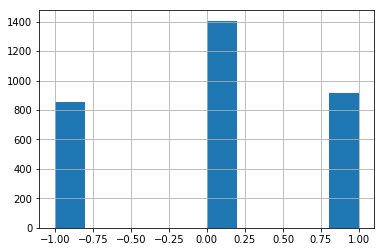

In [455]:
gold['target'].hist()

In [456]:
gold_gains.gains.describe()

count     3172.000000
mean        -7.379571
std       1195.230611
min     -11390.500000
25%       -551.000000
50%         19.000000
75%        598.500000
max       6555.000000
Name: gains, dtype: float64

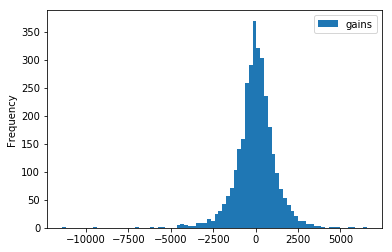

In [457]:
gold_gains[['gains']].plot.hist(bins=80)

In [458]:
gold_gains.head(5)

,gains,Open,High,Low,Settle,target
Date,,,,,,
2006-06-13,-332.5,57000.0,57550.0,56540.0,56650.0,0.0
2006-06-14,-304.0,57350.0,57950.0,56950.0,57030.0,0.0
2006-06-15,47.5,58120.0,58250.0,57050.0,58170.0,0.0
2006-06-16,-38.0,57280.0,57840.0,57100.0,57240.0,0.0
2006-06-19,807.5,57200.0,58100.0,56780.0,58050.0,1.0


In [459]:
def stop_loss_gen(df):
    df['Open_High'] = df['High'] - df['Open']
    df['Open_Low'] = df['Open'] - df['Low']
    return df

In [460]:
gold_gains = stop_loss_gen(gold_gains)

In [461]:
def plot_histogram_cumsum(df, column):
    df[column].hist(bins=50, density=True, cumulative=-1, figsize=(10,5))
    df[column].hist(bins=50, density=True, linewidth=1.5, cumulative=True, histtype='step', figsize=(10,5))
    plt.plot([0, df[column].max()], [0.9, 0.9], lw=1, color='r')

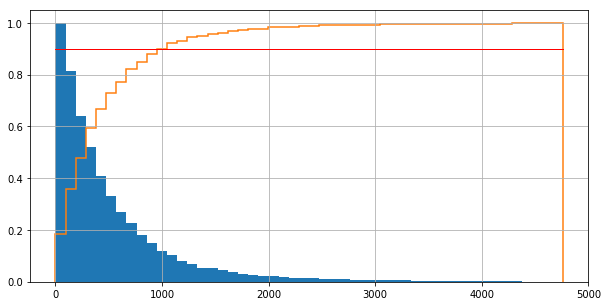

In [462]:
plot_histogram_cumsum(gold_gains[gold_gains.target == 1], 'Open_Low')

In [463]:
gold_gains[gold_gains.target == 1].Open_Low.describe()

count     913.000000
mean      461.412924
std       529.835167
min         0.000000
25%       130.000000
50%       300.000000
75%       620.000000
max      4760.000000
Name: Open_Low, dtype: float64

In [464]:
gold_gains[gold_gains.target == -1].Open_High.describe()

count     853.000000
mean      417.268464
std       430.795933
min         0.000000
25%       140.000000
50%       310.000000
75%       560.000000
max      4380.000000
Name: Open_High, dtype: float64

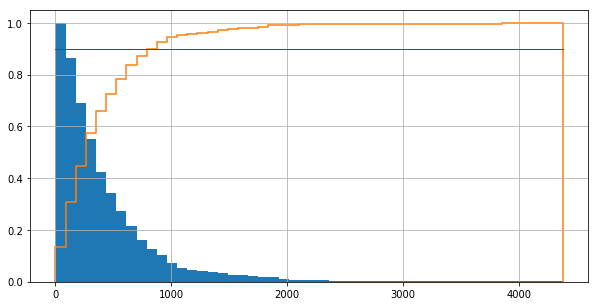

In [465]:
plot_histogram_cumsum(gold_gains[gold_gains.target == -1], 'Open_High')

/anaconda3/envs/capstone-36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


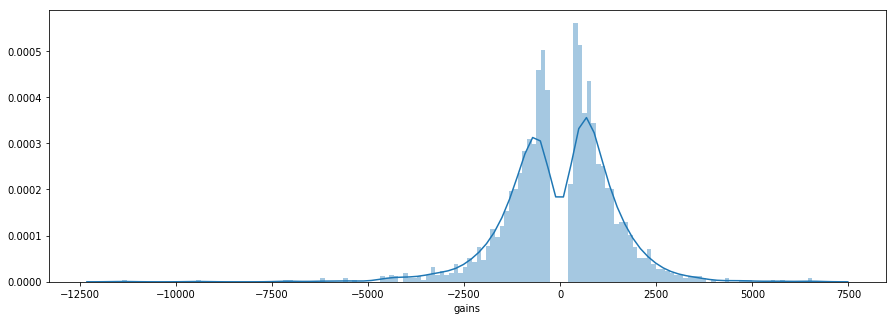

In [466]:
sr = gold_gains.loc[gold_gains.index < '2018-01-01'][gold_gains.gains.abs() > 300].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=150, ax=ax)

In [467]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
threshold = 150
corn_gains = create_trade_outcomes(corn, contracts, threshold)
corn_gains_train = corn_gains.loc[corn_gains.index < '2018-1-1']

              gains     Open     High      Low   Settle  target
Date                                                           
2006-06-13 -213.750  12387.5  12400.0  12112.5  12162.5      -1
2006-06-14 -332.500  12200.0  12262.5  11837.5  11850.0      -1
2006-06-15 -213.750  11875.0  11937.5  11600.0  11650.0      -1
2006-06-16   71.250  12987.5  13137.5  12962.5  13062.5       0
2006-06-19 -154.375  12950.0  13050.0  12750.0  12787.5      -1


In [468]:
corn_gains_train.gains.describe()

count    2917.000000
mean        6.122729
std       411.069273
min     -1983.125000
25%      -190.000000
50%        11.875000
75%       213.750000
max      1888.125000
Name: gains, dtype: float64

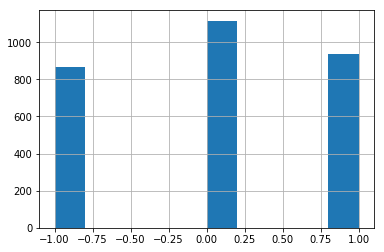

In [469]:
get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

corn.loc[corn.index < '2018-1-1'].target.hist()

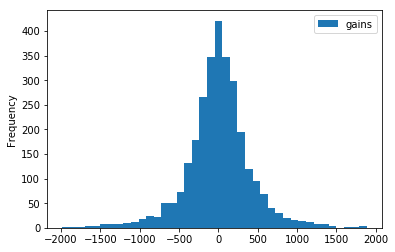

In [470]:
corn_gains_train[['gains']].plot.hist(bins=40)

In [471]:
corn_gains_train.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
2006-06-13,-332.500,12200.0,12262.5,11837.5,11850.0,-1.0
2006-06-14,-213.750,11875.0,11937.5,11600.0,11650.0,-1.0
2006-06-15,71.250,12987.5,13137.5,12962.5,13062.5,0.0
2006-06-16,-154.375,12950.0,13050.0,12750.0,12787.5,-1.0
2006-06-19,-23.750,12825.0,12837.5,12675.0,12800.0,0.0
2006-06-20,142.500,12800.0,12975.0,12775.0,12950.0,0.0
2006-06-21,-95.000,12950.0,13025.0,12800.0,12850.0,0.0
2006-06-22,-83.125,12850.0,12887.5,12737.5,12762.5,0.0
2006-06-23,-225.625,12687.5,12687.5,12387.5,12450.0,-1.0


In [472]:
corn_gains = stop_loss_gen(corn_gains)
corn_gains_train = corn_gains[corn_gains.index < '2018-1-1']

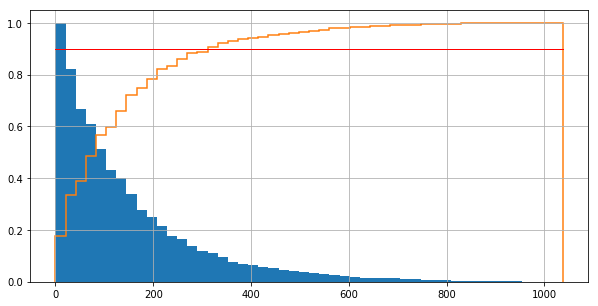

In [473]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == 1], 'Open_Low')

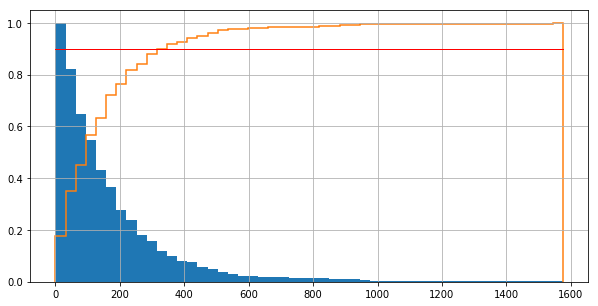

In [474]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == -1], 'Open_High')

/anaconda3/envs/capstone-36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


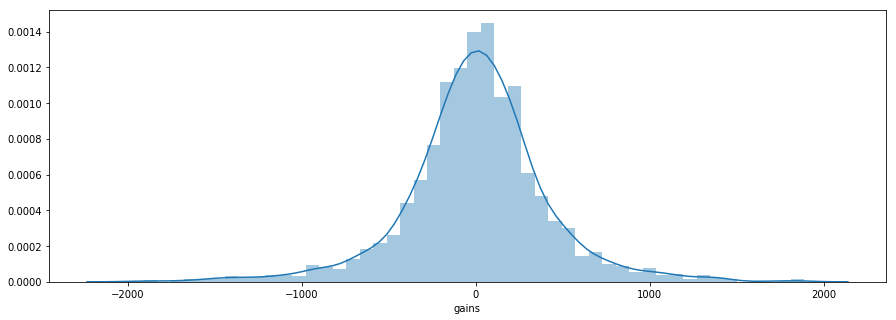

In [475]:
sr = corn_gains_train.gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, ax=ax)

/anaconda3/envs/capstone-36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


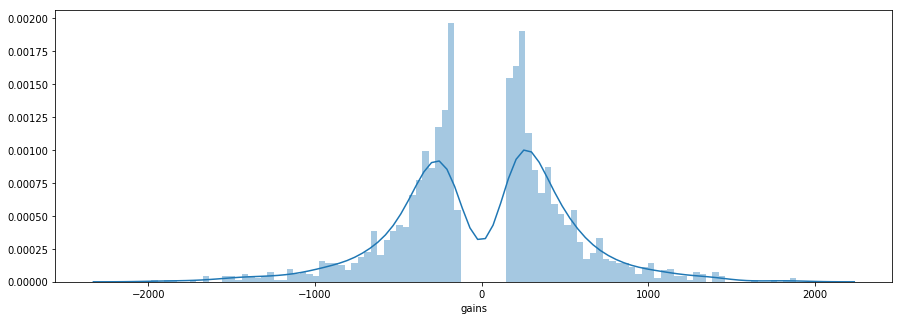

In [476]:
sr = corn_gains_train[corn_gains.gains.abs() > 150].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=100, ax=ax)

In [477]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
threshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, threshold)
coffee_gains = stop_loss_gen(coffee_gains)
coffee_gains_train = coffee_gains.loc[coffee_gains.index < '2018-1-1']

            gains      Open     High      Low    Settle  target
Date                                                           
2006-06-13    0.0  36731.25  37050.0  36712.5  36731.25       0
2006-06-14    0.0  36918.75  37275.0  36600.0  36918.75       0
2006-06-15    0.0  37106.25  37425.0  36937.5  37106.25       0
2006-06-16    0.0  36637.50  37350.0  36337.5  36637.50       0
2006-06-19    0.0  36468.75  36712.5  36375.0  36468.75       0


In [478]:
coffee_gains_train.gains.describe()

count    2908.000000
mean      -11.546273
std      1070.462227
min     -5236.875000
25%      -516.562500
50%         0.000000
75%       498.750000
max      6341.250000
Name: gains, dtype: float64

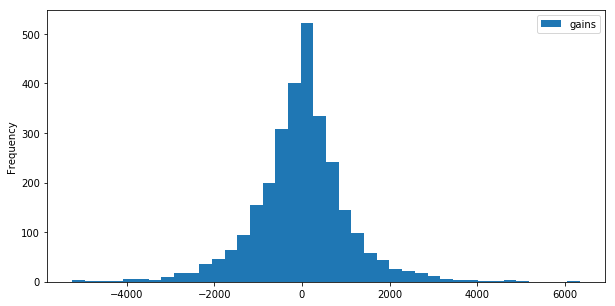

In [479]:
coffee_gains_train[['gains']].plot.hist(bins=40, figsize=(10, 5))

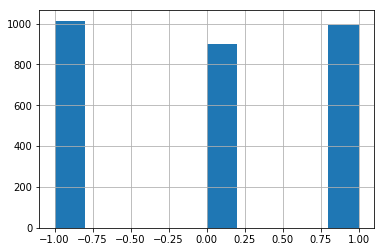

In [480]:
get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
coffee.loc[coffee.index < '2018-1-1'].target.hist()

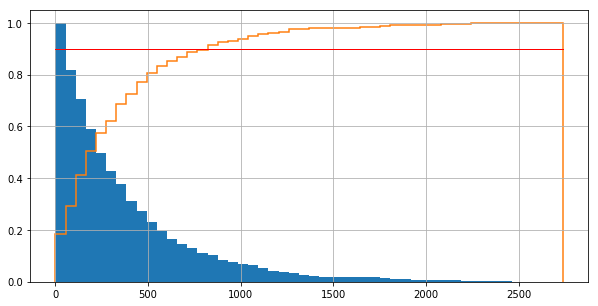

In [481]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == 1], 'Open_Low')

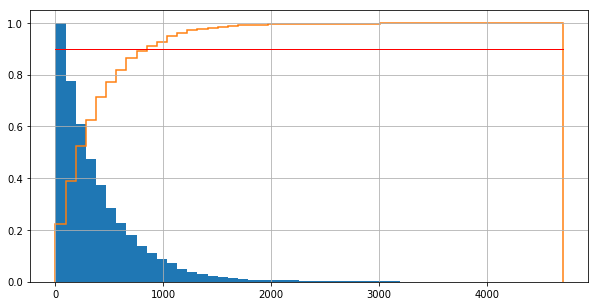

In [482]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == -1], 'Open_High')

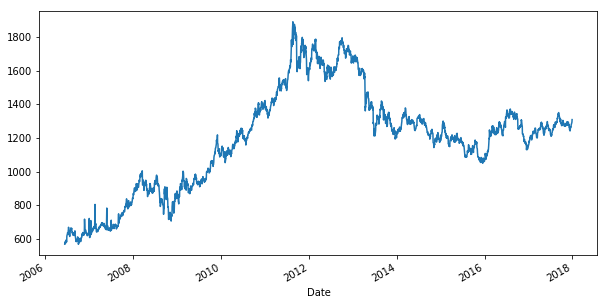

In [483]:
gold.loc[gold.index < '2018-01-01']['Settle'].plot(figsize=(10, 5))

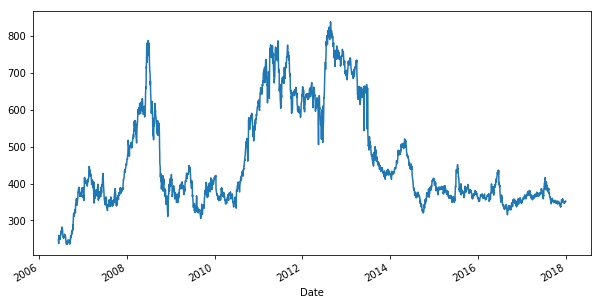

In [484]:
corn.loc[corn.index < '2018-01-01']['Open'].plot(figsize=(10, 5))

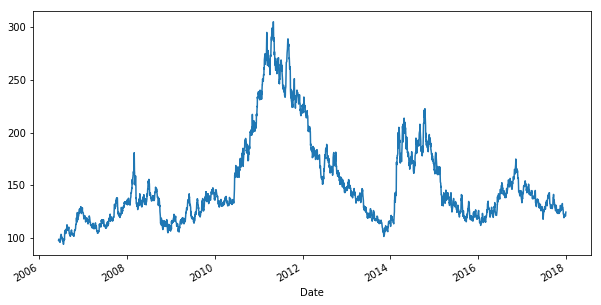

In [485]:
coffee.loc[coffee.index < '2018-01-01']['Open'].plot(figsize=(10, 5))

In [486]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_cycle(x, period):
    sn = np.sin(x*(2.*np.pi/period))
    cs = np.cos(x*(2.*np.pi/period))
    return sn, cs


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        wsn, wcs = create_cycle(dt.weekday(), 5)
        # period for trading day in month is at most 23
        tsn, tcs = create_cycle(trading_day_of_month(idx), 23)
        dsn, dcs = create_cycle(dt.month, 12)
        qsn, qcs = create_cycle((dt.month-1)//3, 4)
        mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [487]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

In [488]:
gold_data.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,3040,3041,3042,3043,3044,3045,3046,3047,3048,3049
2018-12-03,1175.1,1178.4,1162.2,1169.4,216866.0,273896.0,1174.3,1180.3,1168.4,1177.8,...,0.000000,1.000000,0.269797,0.962917,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.826484,1.0
2018-12-04,1174.3,1180.3,1168.4,1177.8,169593.0,273718.0,1182.6,1190.2,1158.6,1176.5,...,0.951057,0.309017,0.519584,0.854419,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.821862,0.0
2018-12-05,1182.6,1190.2,1158.6,1176.5,212507.0,275782.0,1172.8,1177.1,1168.1,1170.1,...,0.587785,-0.809017,0.730836,0.682553,-2.449294e-16,1.0,-1.0,-1.836970e-16,12.128713,0.0
2018-12-06,1172.8,1177.1,1168.1,1170.1,131034.0,271766.0,1171.4,1182.3,1167.2,1177.5,...,-0.587785,-0.809017,0.887885,0.460065,-2.449294e-16,1.0,-1.0,-1.836970e-16,15.989848,1.0
2018-12-07,1171.4,1182.3,1167.2,1177.5,138151.0,269789.0,1176.1,1180.7,1170.9,1172.4,...,-0.951057,0.309017,0.979084,0.203456,-2.449294e-16,1.0,-1.0,-1.836970e-16,7.064018,-1.0
2018-12-10,1176.1,1180.7,1170.9,1172.4,142683.0,272867.0,1172.5,1173.8,1157.6,1161.9,...,0.000000,1.000000,0.997669,-0.068242,-2.449294e-16,1.0,-1.0,-1.836970e-16,15.618221,0.0
2018-12-11,1172.5,1173.8,1157.6,1161.9,154624.0,270743.0,1161.4,1167.9,1152.5,1165.8,...,0.951057,0.309017,0.942261,-0.334880,-2.449294e-16,1.0,-1.0,-1.836970e-16,20.390456,0.0
2018-12-12,1161.4,1167.9,1152.5,1165.8,159925.0,270195.0,1164.5,1167.0,1156.3,1159.0,...,0.587785,-0.809017,0.816970,-0.576680,-2.449294e-16,1.0,-1.0,-1.836970e-16,14.316703,0.0
2018-12-13,1164.5,1167.0,1156.3,1159.0,136465.0,272335.0,1159.8,1168.0,1140.0,1163.7,...,-0.587785,-0.809017,0.631088,-0.775711,-2.449294e-16,1.0,-1.0,-1.836970e-16,19.956616,0.0
2018-12-14,1159.8,1168.0,1140.0,1163.7,206337.0,272962.0,1143.8,1146.0,1124.3,1129.8,...,-0.951057,0.309017,0.398401,-0.917211,-2.449294e-16,1.0,-1.0,-1.836970e-16,32.971800,1.0


In [489]:
gold_data.shape

(2669, 3050)

In [490]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [491]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

In [492]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 3049
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)
    
    pca = PCA(n_components=20, random_state=2234)
    # pca = FactorAnalysis(n_components=5, random_state=2234)
    pca.fit(df_train[list(range(label_index))])
    
    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 3049
    df_pca = pca.transform(df[list(range(label_index))])
    
    # df_pca = np.concatenate((df_pca, df[list(range(3040,label_index))].values), axis=1)
    return df_pca

In [493]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
# gold_train, gold_label_train, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

### Dimension reduction with PCA

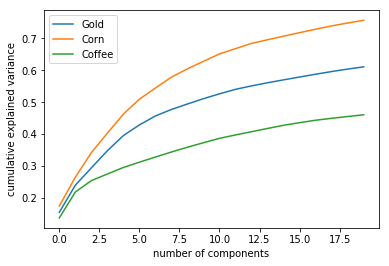

In [494]:
plt.plot(np.cumsum(gold_pca.explained_variance_ratio_), label='Gold')
plt.plot(np.cumsum(corn_pca.explained_variance_ratio_), label='Corn')
plt.plot(np.cumsum(coffee_pca.explained_variance_ratio_), label='Coffee')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.legend()
plt.show()

In [495]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [496]:
gold_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,3040,3041,3042,3043,3044,3045,3046,3047,3048,3049
2008-06-06,590.5,595.0,565.5,566.8,93899.0,192616.0,570.0,575.5,565.4,566.5,...,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,53.766617,-1.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,192917.0,573.5,579.5,569.5,570.3,...,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,55.096012,-1.0
2008-06-10,573.5,579.5,569.5,570.3,52628.0,193887.0,581.2,582.5,570.5,581.7,...,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,93.449782,1.0
2008-06-11,581.2,582.5,570.5,581.7,43947.0,189585.0,572.8,578.4,571.0,572.4,...,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,76.419214,-1.0
2008-06-12,572.8,578.4,571.0,572.4,27362.0,189168.0,572.0,581.0,567.8,580.5,...,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,82.535211,0.0
2008-06-13,572.0,581.0,567.8,580.5,39962.0,187696.0,577.0,591.5,573.5,591.0,...,-0.951057,0.309017,0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,80.985915,1.0
2008-06-16,577.0,591.5,573.5,591.0,43918.0,187072.0,588.0,593.5,584.5,585.4,...,0.000000,1.000000,0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,49.527410,0.0
2008-06-17,588.0,593.5,584.5,585.4,42916.0,187027.0,574.5,589.0,574.5,588.0,...,0.951057,0.309017,-0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,48.393195,1.0
2008-06-18,574.5,589.0,574.5,588.0,33705.0,181290.0,586.2,589.5,580.0,587.7,...,0.587785,-0.809017,-0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,35.916824,1.0
2008-06-19,586.2,589.5,580.0,587.7,30510.0,181460.0,589.5,599.0,583.7,584.4,...,-0.587785,-0.809017,-0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,15.689981,0.0


In [497]:
import os
import platform

print(platform.platform())

if platform.system() == 'Darwin':
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

Darwin-18.2.0-x86_64-i386-64bit


In [498]:
%%capture cpt_gold_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
import lightgbm as lgb
# import xgboost as xgb

categoricals = [10, 11, 12, 13]
X = pca_transform(gold_train, gold_pca)
y = list(map(lambda x: 1 if x < 0 else 0, gold_label_train))
train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals) # categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(gold_test, gold_pca)
y_test = list(map(lambda x: 1 if x < 0 else 0, gold_label_test))
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)

gold_short = True

param = {}
param['num_leaves'] = 31
param['objective'] = 'binary'
param['boosting'] = 'dart'
param['metric'] = 'binary_error'
param['learning_rate'] = 0.05
param['num_class'] = 1
param['max_bin'] = 40
param['reg_alpha'] = 5
param['reg_lambda'] = 10
num_round = 100

gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

In [499]:
%%capture cpt_corn_train
X = pca_transform(corn_train, corn_pca)
y = list(map(lambda x: 1 if x < 0 else 0, corn_label_train))
train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals)
X_test = pca_transform(corn_test, corn_pca)
y_test = list(map(lambda x: 1 if x < 0 else 0, corn_label_test))
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)
corn_short = True
corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

In [500]:
%%capture cpt_coffee_train
X = pca_transform(coffee_train, coffee_pca)
y = list(map(lambda x: 1 if x < 0 else 0, coffee_label_train))
train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals)
X_test = pca_transform(coffee_test, coffee_pca)
y_test = list(map(lambda x: 1 if x < 0 else 0, coffee_label_test))
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)
coffee_short = True
coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

In [501]:
# rework with numpy cumsum

def get_performance(model, pca, df_gains, df, labels, short=gold_short, multi_class=False, stop_loss=500, vector=False):
    global account_size, fee
    acc = account_size
    df = pca_transform(df, pca)
    if short:
        target = -1.0
    else:
        target = 1.0
    preds = model.predict(df)
    # print(np.unique(preds))
    if vector:
        preds = [p[0] for p in preds]
        # ps = []
        # for p, r in preds:
        #     if p > 0.5 and p > r:
        #         ps.append(p)
        # preds = ps
    predictions = []
    if not multi_class:
        mx = 0
        for p in preds:
            # print(p)
            if p > mx:
                # print(mx)
                mx = p
            if p > 0.5:
                predictions.append(target)
            else:
                predictions.append(0)
    else:
        mx = 0
        for t, n in preds:
            # if t > mx:
            #     print(mx)
            #     mx = t
            if t > 0.5:
                print(t, n)
                predictions.append(target)
            else:
                predictions.append(0)
    dct = {}
    dct['account'] = [acc]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['short'] = [0]
    dct['long'] = [0]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['stop_loss'] = [0]
    dct['gains'] = [0]
    for p, l, v in zip(predictions, labels, df_gains.values):
        # print(p, l)
        # print(p,l)
        # print(p)
        short = 0
        long = 0
        s_l = 0
        gains = 0
        if p == -1.0:
            # print("Short ", p, l)
            short = 1
            if (v[2] - v[1]) > stop_loss:
                gains = -stop_loss
                s_l = 1
            else:
                gains = -v[0] - fee
        elif p == 1.0:
            long = 1
            if (v[1] - v[3]) > stop_loss:
                gains = -stop_loss
                s_l = 1
            else:
                gains = v[0] - fee
        acc += gains
        dct['account'].append(acc)
        dct['short'].append(short)
        dct['long'].append(long)
        dct['stop_loss'].append(s_l)
        dct['trade'].append(p)
        dct['label'].append(l)
        dct['gains'].append(gains)
        if acc <= 0:
            break
    return pd.DataFrame.from_dict(dct)

(0, 21946.50000000002)

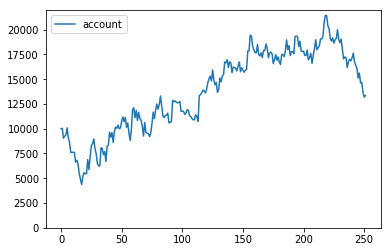

In [502]:
gold_account = get_performance(gold_clf, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, short=True, stop_loss=1000)
ax1 = gold_account[['account']].plot()
ax1.set_ylim(0,gold_account.account.max()+500)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a7319f390>,
      dtype=object)

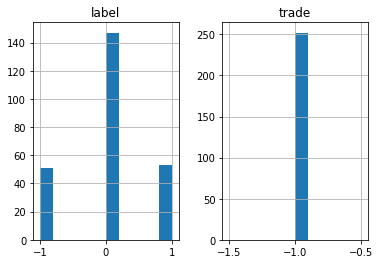

In [503]:
gold_account[gold_account.short == 1][['label', 'trade']].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a7319f470>,
      dtype=object)

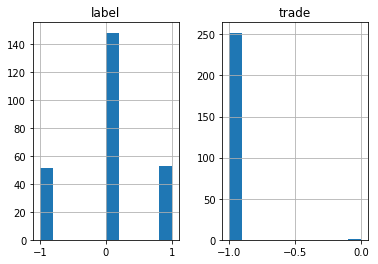

In [504]:
gold_account[['trade', 'label']].hist()

In [505]:
gold_account[gold_account['short'] == 1].gains.sum()

3350.999999999935

In [506]:
gold_account[gold_account['long'] == 1].gains.sum()

0.0

(0, 10500)

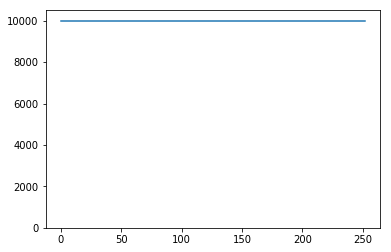

In [507]:
corn_account = get_performance(corn_clf, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, short=True, stop_loss=400)
ax1 = corn_account.account.plot()
ax1.set_ylim(0,corn_account.account.max()+500)

In [508]:
corn_account[corn_account['short'] == 1].gains.sum()

0

In [509]:
corn_account[corn_account['long'] == 1].gains.sum()

0

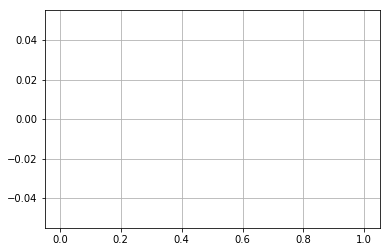

In [510]:
corn_account[corn_account.short == 1].label.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a72b57b38>,
      dtype=object)

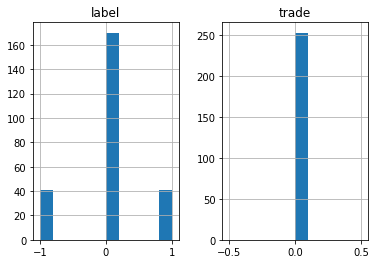

In [511]:
corn_account[['trade', 'label']].hist()

(0, 10500)

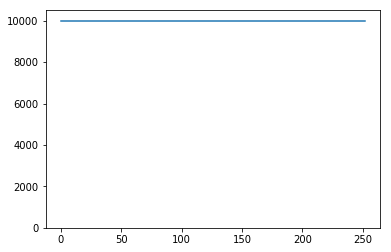

In [512]:
coffee_account = get_performance(coffee_clf, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_validate, coffee_label_validate, short=coffee_short, stop_loss=1000)
ax1 = coffee_account.account.plot()
ax1.set_ylim(0,coffee_account.account.max()+500)

In [513]:
coffee_account[coffee_account['short'] == 1].gains.sum()

0

In [514]:
coffee_account[coffee_account['long'] == 1].gains.sum()

0

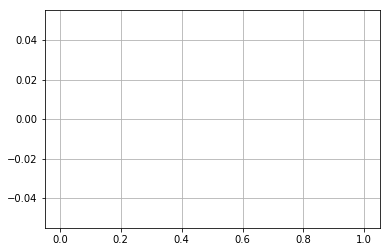

In [515]:
coffee_account[coffee_account.short == 1].label.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3f886f98>,
      dtype=object)

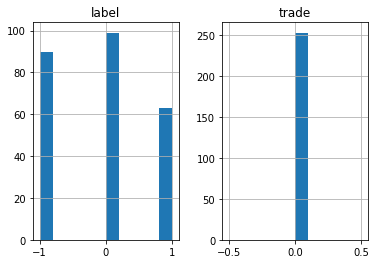

In [516]:
coffee_account[['trade', 'label']].hist()

In [517]:
# %%capture gold_long_train
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier

X = pca_transform(gold_train, gold_pca)
y = list(map(lambda x: 1 if x > 0 else 0, gold_label_train))
X_test = pca_transform(gold_test, gold_pca)
y_test = list(map(lambda x: 1 if x > 0 else 0, gold_label_test))

gold_clf_long = MLPClassifier(solver='lbfgs', alpha=1e-2,
                              hidden_layer_sizes=(10, 20, 2), random_state=55431)
gold_clf_long.fit(np.concatenate([X, X_test]), np.concatenate([y, y_test]))

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 20, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=55431, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [518]:
%%capture training_gold
from keras.layers import Dropout, Flatten, Dense, Activation, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.models import Sequential
from keras import regularizers

X_train = np.concatenate([X, X_test])
y_train = np.array([[1,0] if i==1 else [0,0] for i in np.concatenate([y, y_test])])

input_shape = 20
num_classes = 1

# Define a model
model = Sequential()  
model.add(Dense(64, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))

opt = Nadam(lr=0.002)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50)

model.summary()

In [519]:
gold_clf_long = model

0.99991703 8.299704e-05
0.9999174 8.2583734e-05
0.99991786 8.209183e-05
0.99991846 8.158466e-05
0.9999186 8.135461e-05
0.9999186 8.138666e-05
0.99991834 8.166591e-05
0.99991775 8.2238585e-05
0.9999169 8.3105224e-05
0.99991596 8.399828e-05
0.9999155 8.457184e-05
0.9999149 8.515124e-05
0.9999144 8.558872e-05
0.99991405 8.591942e-05
0.99991405 8.591483e-05
0.99991417 8.578753e-05
0.99991465 8.529361e-05
0.9999157 8.423933e-05
0.9999167 8.335674e-05
0.9999174 8.265181e-05
0.99991775 8.227459e-05
0.9999176 8.235246e-05
0.99991703 8.2919585e-05
0.99991643 8.350344e-05
0.99991584 8.419797e-05
0.99991536 8.467197e-05
0.999915 8.4936975e-05
0.9999151 8.4834166e-05
0.9999156 8.443951e-05
0.9999162 8.38284e-05
0.9999169 8.3051265e-05
0.99991834 8.1656406e-05
0.9999193 8.0708705e-05
0.9999201 7.9908736e-05
0.9999206 7.941177e-05
0.9999207 7.9304475e-05
0.9999206 7.938975e-05
0.99992037 7.960117e-05
0.99992025 7.977017e-05
0.9999205 7.956072e-05
0.9999205 7.953577e-05
0.99992096 7.903947e-05
0.9999

(0, 18000)

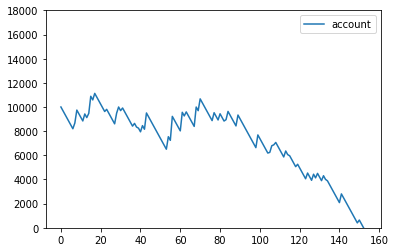

In [520]:
gold_account_long = get_performance(gold_clf_long, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, short=False, stop_loss=300, multi_class=True, vector=False)
ax1 = gold_account_long[['account']].plot()
ax1.set_ylim(0,18000)

In [521]:
gold_account_long[gold_account_long['long'] == 1].gains.sum()

-10257.499999999936

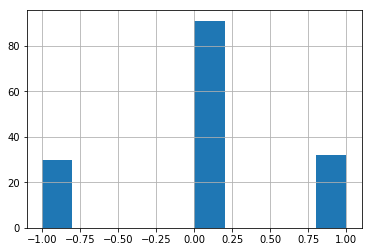

In [522]:
gold_account_long[gold_account_long['long'] == 1].label.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a4311d588>,
      dtype=object)

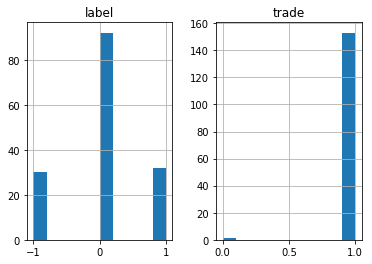

In [523]:
gold_account_long[['trade', 'label']].hist()

In [524]:
# %%capture cpt_corn_train
import keras_metrics
X = pca_transform(corn_train, corn_pca)
X_test = pca_transform(corn_test, corn_pca)

y = list(map(lambda x: 1 if x > 0 else 0, corn_label_train))
y_test = list(map(lambda x: 1 if x > 0 else 0, corn_label_test))

model = Sequential()  
model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
model.add(LeakyReLU())
model.add(Dense(1))
model.add(Activation('softmax'))

opt = Nadam(lr=0.02)

model.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=[keras_metrics.precision()])
model.fit(X, y, epochs=20, validation_data=(X_test, y_test), batch_size=128, shuffle=True)

model.summary()

corn_clf_long = model

Train on 1930 samples, validate on 483 samples
Epoch 1/20
1930/1930 [==============================] - 3s 2ms/step - loss: 9761177476347.4902 - precision: 0.3124 - val_loss: 1284906548026.8323 - val_precision: 0.2981
Epoch 2/20
1930/1930 [==============================] - 0s 91us/step - loss: 470723400807.1959 - precision: 0.3124 - val_loss: 33273078311.2215 - val_precision: 0.2981
Epoch 3/20
1930/1930 [==============================] - 0s 97us/step - loss: 18941040320.6964 - precision: 0.3124 - val_loss: 7781956447.9337 - val_precision: 0.2981
Epoch 4/20
1930/1930 [==============================] - 0s 156us/step - loss: 3925225622.5451 - precision: 0.3124 - val_loss: 571571174.0290 - val_precision: 0.2981
Epoch 5/20
1930/1930 [==============================] - 0s 139us/step - loss: 202419254.1088 - precision: 0.3124 - val_loss: 17625894.4120 - val_precision: 0.2981
Epoch 6/20
1930/1930 [==============================] - 0s 79us/step - loss: 8808961.4882 - precision: 0.3124 - val_loss:

(0, 18000)

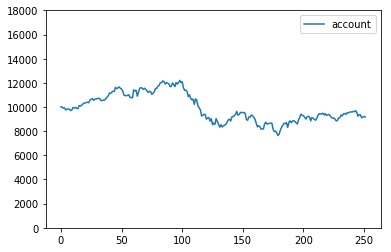

In [525]:
corn_account_long = get_performance(corn_clf_long, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, short=False, stop_loss=500, vector=True, multi_class=False)
ax1 = corn_account_long[['account']].plot()
ax1.set_ylim(0,18000)

In [526]:
corn_account_long[corn_account_long['long'] == 1].gains.sum()

-814.1250000000002

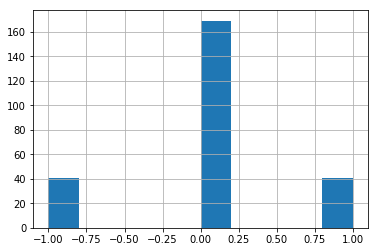

In [527]:
corn_account_long[corn_account_long['long'] == 1].label.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a4d54b2e8>,
      dtype=object)

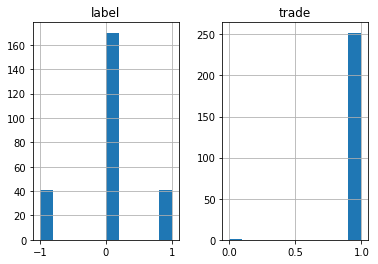

In [528]:
corn_account_long[['trade', 'label']].hist()

In [529]:
# %%capture cpt_coffee_train
param['max_bin'] = 10
X = pca_transform(coffee_train, coffee_pca)
X_test = pca_transform(coffee_test, coffee_pca)
y = list(map(lambda x: 1 if x < 0 else 0, coffee_label_test))
model = Sequential()  
model.add(Dense(64, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))

opt = Nadam(lr=0.002)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2)

model.summary()

coffee_clf_long = model
# coffee_clf_long = lgb.train(param, train_data, num_round, valid_sets=[test_data])

Epoch 1/2
2417/2417 [==============================] - 6s 2ms/step - loss: 780918610344.5131 - acc: 0.7125
Epoch 2/2
2417/2417 [==============================] - 1s 277us/step - loss: 148230294288.6289 - acc: 0.9483
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 64)                1344      
_________________________________________________________________
batch_normalization_21 (Batc (None, 64)                256       
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 16)                1040      
__________________________________________________________

(0, 20000)

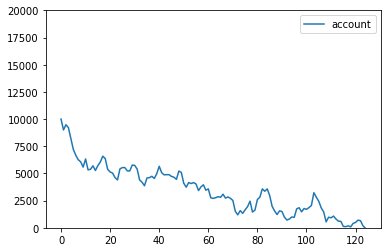

In [530]:
coffee_account_long = get_performance(coffee_clf_long, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], corn_validate, coffee_label_validate, short=False, stop_loss=1000, vector=True)
ax1 = coffee_account_long[['account']].plot()
ax1.set_ylim(0,20000)

In [531]:
coffee_account_long.head(10)

,account,trade,label,short,long,stop_loss,gains
0,10000.0000,0.0,0.0,0,0,0,0.0000
1,9000.0000,1.0,-1.0,0,1,1,-1000.0000
2,9479.4375,1.0,1.0,0,1,0,479.4375
3,9210.7500,1.0,0.0,0,1,0,-268.6875
4,8210.7500,1.0,-1.0,0,1,1,-1000.0000
5,7210.7500,1.0,0.0,0,1,1,-1000.0000
6,6674.8750,1.0,-1.0,0,1,0,-535.8750
7,6263.6875,1.0,-1.0,0,1,0,-411.1875
8,6066.2500,1.0,0.0,0,1,0,-197.4375
9,5583.8125,1.0,-1.0,0,1,0,-482.4375


In [532]:
# mean reversal
# Compute the z-scores for each day using the historical data up to that day
def mean_reversal_account(df, df_gains, trade_days=1):
    account = 10000
    direction = gold['mean_direction'].values[0]
    dct = {}
    dct['account'] = [account]
    trade = 0
    for d, v in zip(df['mean_direction'].values, gold_gains.values):
        if d >= 0 and direction <= 0:
            account -= v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        elif d <= 0 and direction >= 0:
            direction = d
            account += v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        dct['account'].append(account)
        if account <= 0:
            break
    return pd.DataFrame.from_dict(dct)

def mean_calculation(df, big_range, small_range):
    big_mean = 'mean_' + str(big_range)
    small_mean = 'mean_' + str(small_range)
    df[big_mean] = df.rolling(str(big_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df[small_mean] = df.rolling(str(small_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df['mean_direction'] =  df[small_mean] - df[big_mean]
    return df

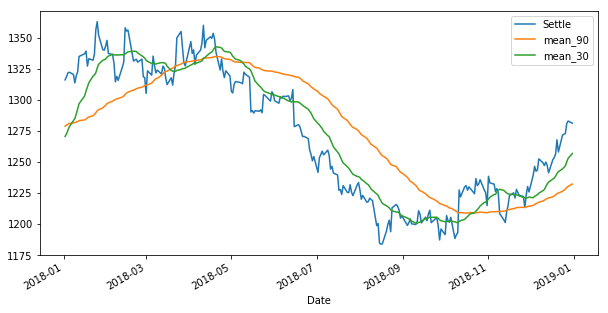

In [533]:
gold = mean_calculation(gold, 90, 30)
gold[['Settle', 'mean_90', 'mean_30']].loc[gold.index > validate_date].plot(figsize=(10,5))

In [534]:
# dow_amount = 10000/dow[dow.index == '2018-01-01'].Settle
# print(dow.loc[(dow.index >= '2018-01-01') & (dow.index < '2018-01-02')].Settle)
# print(dow_amount)
nasdaq_amount = 10000/nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

nasdaq = nasdaq.loc[(nasdaq.index <= '2018-12-31')]
# dow = dow.loc[(dow.index <= '2018-12-31')]
# gold_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}).head()

In [535]:
nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

6514.75

In [536]:
nasdaq_amount

1.5349783184312522

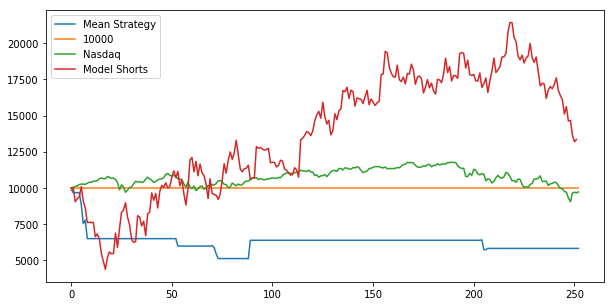

In [537]:
gold_mean = mean_reversal_account(gold.loc[gold.index > validate_date], gold_gains.loc[gold_gains.index > validate_date], trade_days=5)
gold_mean['base'] = gold_mean.account.apply(lambda x: 10000)
gold_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
gold_mean['Nasdaq'] = gold_mean['Nasdaq']*nasdaq_amount

pd.concat([gold_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
           gold_account.rename(columns={'account': 'Model Shorts'})[['Model Shorts']],
          ], 
          axis=1).plot(figsize=(10,5))

In [538]:
gold_mean.head()

,account,base,Nasdaq
0,10000.0,10000,9837.292298
1,9667.5,10000,10000.000000
2,9667.5,10000,10107.064738
3,9667.5,10000,10136.229326
4,9667.5,10000,10234.851683


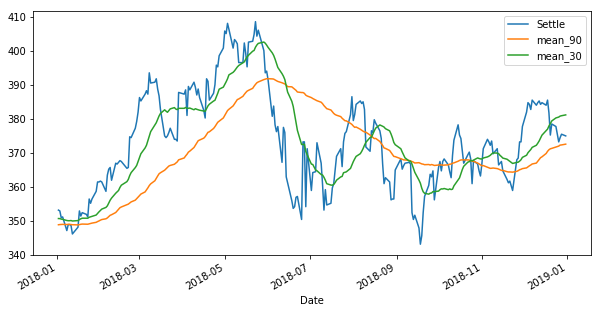

In [539]:
corn = mean_calculation(corn, 90, 30)
corn[['Settle', 'mean_90', 'mean_30']].loc[corn.index > validate_date].plot(figsize=(10,5))

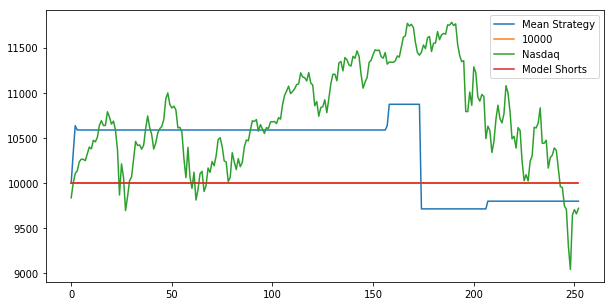

In [540]:
corn_mean = mean_reversal_account(corn.loc[corn.index > validate_date], corn_gains.loc[corn_gains.index > validate_date], trade_days=3)
corn_mean['base'] = corn_mean.account.apply(lambda x: 10000)
corn_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
corn_mean['Nasdaq'] = corn_mean['Nasdaq']*nasdaq_amount

pd.concat([corn_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
           corn_account.rename(columns={'account': 'Model Shorts'})[['Model Shorts']]], 
          axis=1).plot(figsize=(10,5))

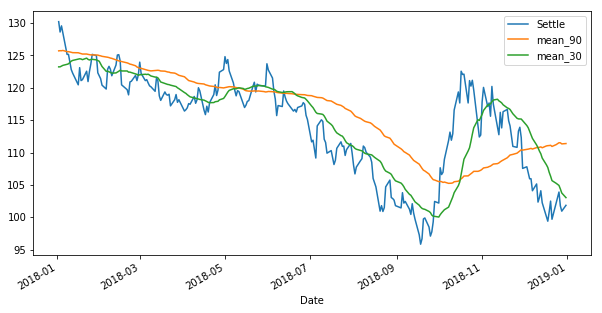

In [541]:
coffee = mean_calculation(coffee, 90, 30)
coffee[['Settle', 'mean_90', 'mean_30']].loc[coffee.index > validate_date].plot(figsize=(10,5))

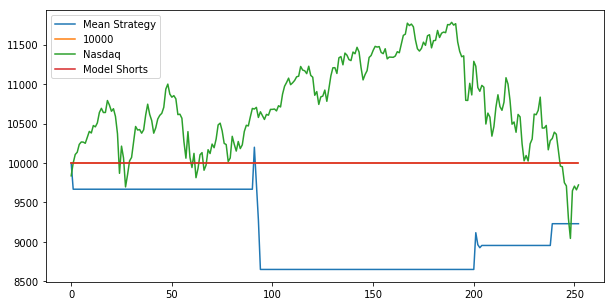

In [544]:
coffee_mean = mean_reversal_account(coffee.loc[coffee.index > validate_date], 
                                    coffee_gains.loc[coffee_gains.index > validate_date], 
                                    trade_days=5)
coffee_mean['base'] = coffee_mean.account.apply(lambda x: 10000)
coffee_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
coffee_mean['Nasdaq'] = coffee_mean['Nasdaq']*nasdaq_amount

pd.concat([coffee_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
           coffee_account.rename(columns={'account': 'Model Shorts'})[['Model Shorts']],
          ], 
          axis=1).plot(figsize=(10,5))